# Data Exploration in Splice Machine
#### Let's start our Spark Session

In [5]:
# Setup
from pyspark.sql import SparkSession
from splicemachine.spark import PySpliceContext
from splicemachine.mlflow_support.utilities import get_user

spark = SparkSession.builder.getOrCreate()
splice = PySpliceContext(spark)
schema = get_user()

## Ingesting Data
<blockquote><p class='quotation'><span style='font-size:15px'> There are a variety of ways to ingest data into splice machine— here we'll use an import from s3 directly into a splice machine table. From there we'll be able to investigate our features. <footer>Splice Machine</footer>
</blockquote>

In [2]:
%%sql
drop table if exists cc_fraud_data; 
create table cc_fraud_data (
    time_offset integer,
    expected_weekly_trans_cnt double,
    expected_weekly_trans_amnt double,
    expected_daily_trans_cnt double,
    expected_daily_trans_amnt double,
    weekly_trans_cnt double,
    weekly_trans_amnt double,
    daily_trans_cnt double,
    daily_trans_amnt double,
    rolling_avg_weekly_trans_cnt double,
    rolling_avg_weekly_trans_amnt double,
    rolling_avg_daily_trans_cnt double,
    rolling_avg_daily_trans_amnt double,
    MACD_trans_amnt double,
    MACD_trans_cnt double,
    RSI_trans_amnt double,
    RSI_trans_cnt double,
    Aroon_trans_amnt double,
    Aroon_trans_cnt double,
    ADX_trans_amnt double,
    ADX_trans_cnt double,
    current_balance double,
    rolling_avg_balance double,
    MACD_balance double,
    Aroon_balance double,
    RSI_balance double,
    ADX_balance double,
    credit_score double,
    credit_limit double,
    amount decimal(10,2),
    class_result int
);

call SYSCS_UTIL.IMPORT_DATA (
     null,
     'cc_fraud_data',
     null,
     's3a://splice-demo/kaggle-fraud-data/creditcard.csv',
     ',',
     null,
     null,
     null,
     null,
     -1,
     's3a://splice-demo/kaggle-fraud-data/bad',
     null, 
     null);
     

Sql started successfully



## We can use `SQL` natively to investigate our data

In [3]:
%%sql
select class_result, count(*) as NUM_OCurrences 
from cc_fraud_data 
group by class_result

In [4]:
%%sql 
SELECT class_result, AVG(expected_weekly_trans_cnt) as avg_expected_weekly_trans_cnt, 
AVG(MACD_trans_amnt) as avg_MACD_trans_amnt, 
AVG(RSI_trans_amnt) as avg_RSI_trans_amnt
from cc_fraud_data
group by class_result

## Using the Native Spark Data Source to get our data in PySpark

In [6]:
df = splice.df(f"SELECT * FROM {schema}.cc_fraud_data")

## Investigating the correlation among our features

/opt/conda/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


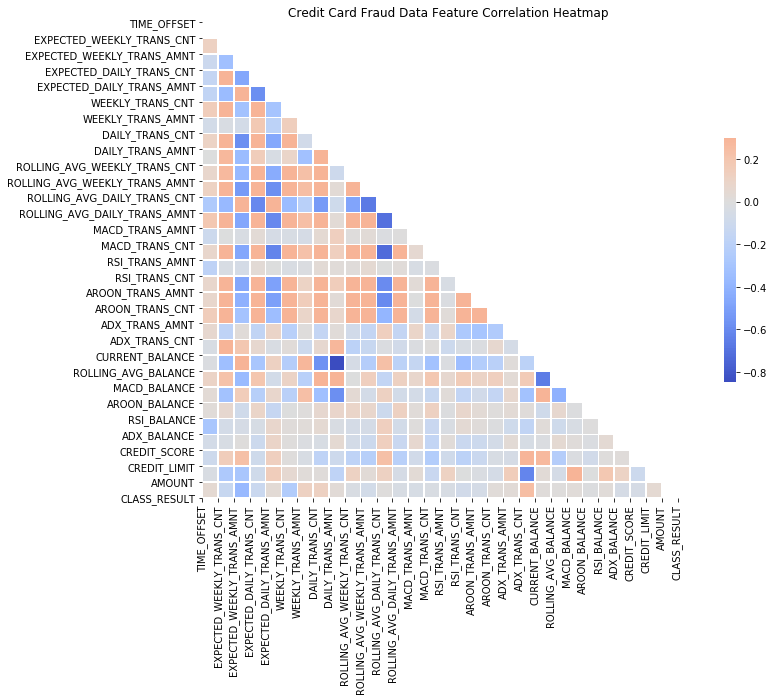

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

pdf = df.filter(df.CLASS_RESULT == 0).limit(900).toPandas()\
        .append(df.filter(df.CLASS_RESULT == 1).limit(100).toPandas())
pdf = pdf.apply(pd.to_numeric)
corr = pdf.corr()

ticks = [i for i in range(len(corr.columns))]
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = "coolwarm"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(ticks, corr.columns)
plt.yticks(ticks, corr.columns)
plt.title('Credit Card Fraud Data Feature Correlation Heatmap')
plt.show()

## Investigating the distribution of our features

In [8]:
features = list(pdf.columns)
features.remove("CLASS_RESULT")

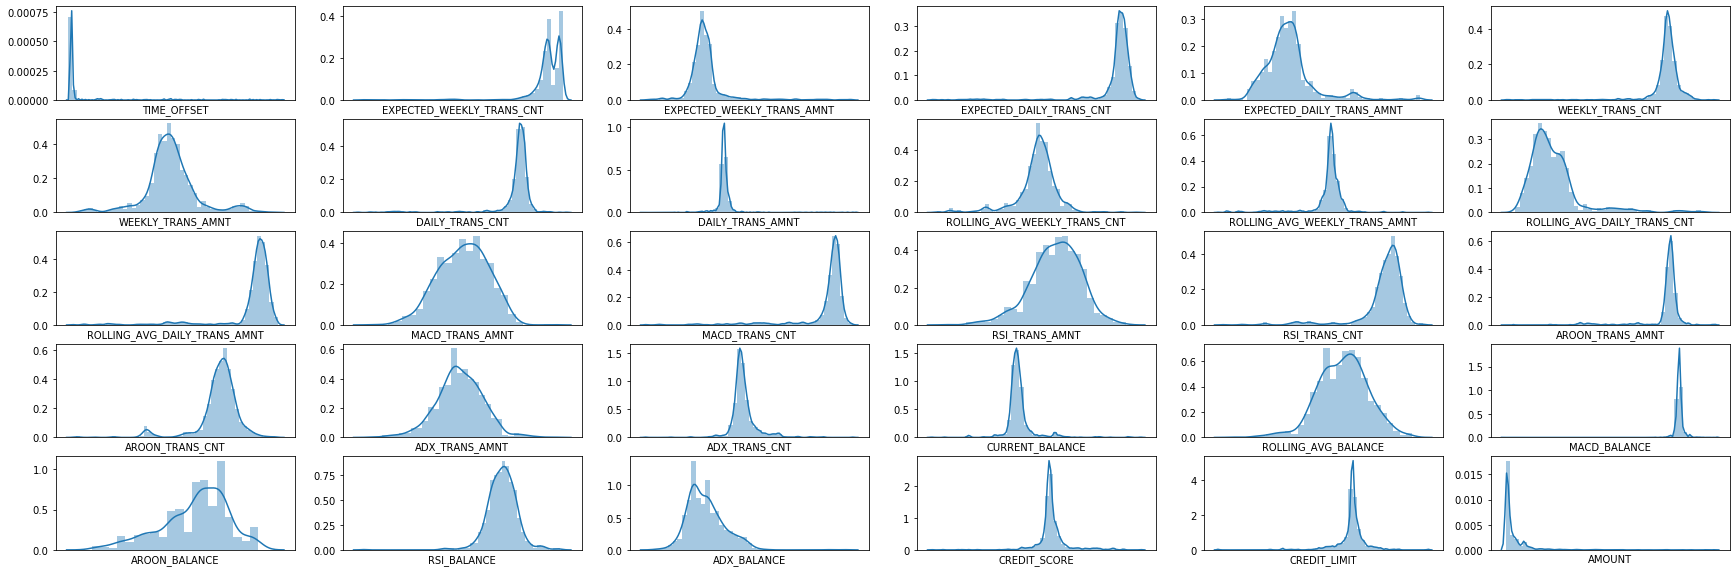

In [74]:
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(30,10))

for i in range(len(features)):
    row = int(i/6)
    col = i%6
    
    axes[row,col] = sns.distplot(pdf[features[i]], ax = axes[row,col])
    axes[row,col].set_xticks([])


## Investigating our features correlation to our target

In [77]:
from beakerx.object import beakerx
beakerx.pandas_display_table()
most_correlated = corr.abs()['CLASS_RESULT'].sort_values(ascending=False).reset_index()
most_correlated = most_correlated.iloc[1:].rename({"index":"feature","CLASS_RESULT":"correlation_to_target"}, axis = 1)
print(most_correlated)

                          feature  correlation_to_target
1                     TIME_OFFSET               0.861746
2    ROLLING_AVG_DAILY_TRANS_AMNT               0.834575
3                  MACD_TRANS_CNT               0.826945
4   ROLLING_AVG_WEEKLY_TRANS_AMNT               0.752052
5     ROLLING_AVG_DAILY_TRANS_CNT               0.739858
6        EXPECTED_DAILY_TRANS_CNT               0.708627
7                AROON_TRANS_AMNT               0.705022
8       EXPECTED_DAILY_TRANS_AMNT               0.696459
9                   RSI_TRANS_CNT               0.683260
10                DAILY_TRANS_CNT               0.663161
11     EXPECTED_WEEKLY_TRANS_AMNT               0.626029
12   ROLLING_AVG_WEEKLY_TRANS_CNT               0.567841
13                AROON_TRANS_CNT               0.545996
14      EXPECTED_WEEKLY_TRANS_CNT               0.538239
15               WEEKLY_TRANS_CNT               0.513323
16              WEEKLY_TRANS_AMNT               0.475171
17               DAILY_TRANS_AM

# Fantastic!
<blockquote> 
We've just demonstrated our platform's ability to execute simple feature investigation routines <br>
    Next Up: <a href='./7.4 Feature Engineering.ipynb'>Using MLManager to Engineer Features</a>
<footer>Splice Machine</footer>
</blockquote>